In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from numpy.linalg import cholesky
import os
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.dates import DateFormatter

import warnings
import itertools

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [7]:
wages_path = 'wages.xlsx'

wages = pd.read_excel(wages_path, engine='openpyxl', usecols = ['time','NSW','VIC','QLD','SA','WA','TAS','NT','ACT'])
wages = pd.DataFrame(wages)
wages = wages.set_index('time').asfreq('QS-DEC')

# Read the Excel file into a pandas DataFrame
wages_pre_covid =wages.iloc[:40]
wages_during_covid =wages.iloc[40:52]
wages_post_covid =wages.iloc[52:]


In [8]:
wages_nsw = wages['NSW']
wages_vic = wages['VIC']
wages_qld = wages['QLD']
wages_sa = wages['SA']
wages_wa = wages['WA']
wages_tas = wages['TAS']
wages_nt = wages['NT']
wages_nt = wages['ACT']

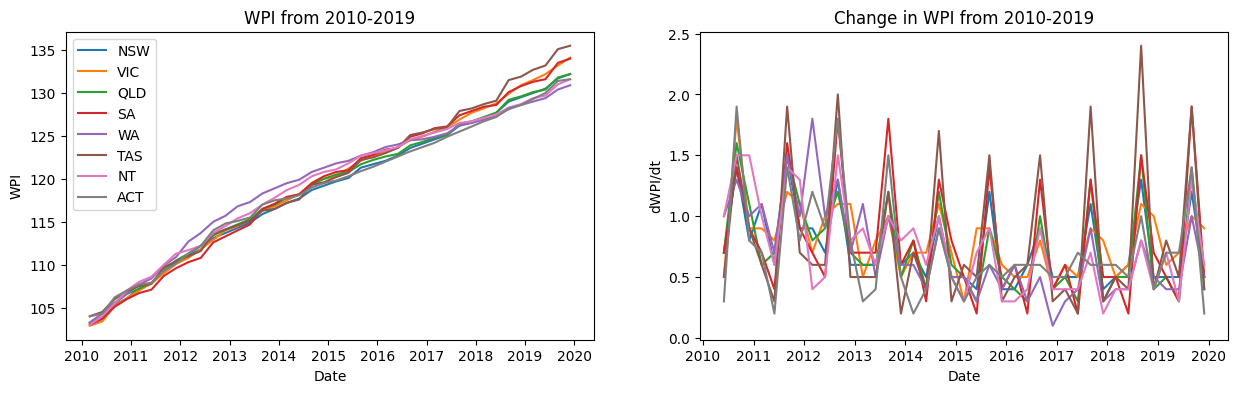

In [9]:
wages = wages.iloc[:40]

f = plt.figure()
f.set_figheight(4)
f.set_figwidth(15)
ax1 = f.add_subplot(121)
ax1.set_title('WPI from 2010-2019')
ax1.set_xlabel('Date')
ax1.set_ylabel('WPI')
ax1.plot(wages)
ax1.legend(wages, loc='best')

wages_change = wages.diff().dropna()
ax2 = f.add_subplot(122)
ax2.set_title('Change in WPI from 2010-2019')
ax2.set_xlabel('Date')
ax2.set_ylabel('dWPI/dt')
ax2.xaxis.set_major_formatter(DateFormatter("%Y"))
ax2.plot(wages_change)




plt.savefig('data overview.png')
# plt.show()


# wages.plot(figsize=(13, 5))
# plt.ylabel("WPI")
# plt.savefig('WPI over states.png')

# wages_change = wages.diff().dropna()
# wages_change.plot(figsize=(13, 5))
# plt.ylabel("d_WPI/dt")
# plt.savefig('change in WPI over states.png')

In [189]:
wages_pre_covid_nsw = wages_pre_covid['NSW']
wages_pre_covid_vic = wages_pre_covid['VIC']
wages_pre_covid_qld = wages_pre_covid['QLD']
wages_pre_covid_sa = wages_pre_covid['SA']
wages_pre_covid_wa = wages_pre_covid['WA']
wages_pre_covid_tas = wages_pre_covid['TAS']
wages_pre_covid_nt = wages_pre_covid['NT']

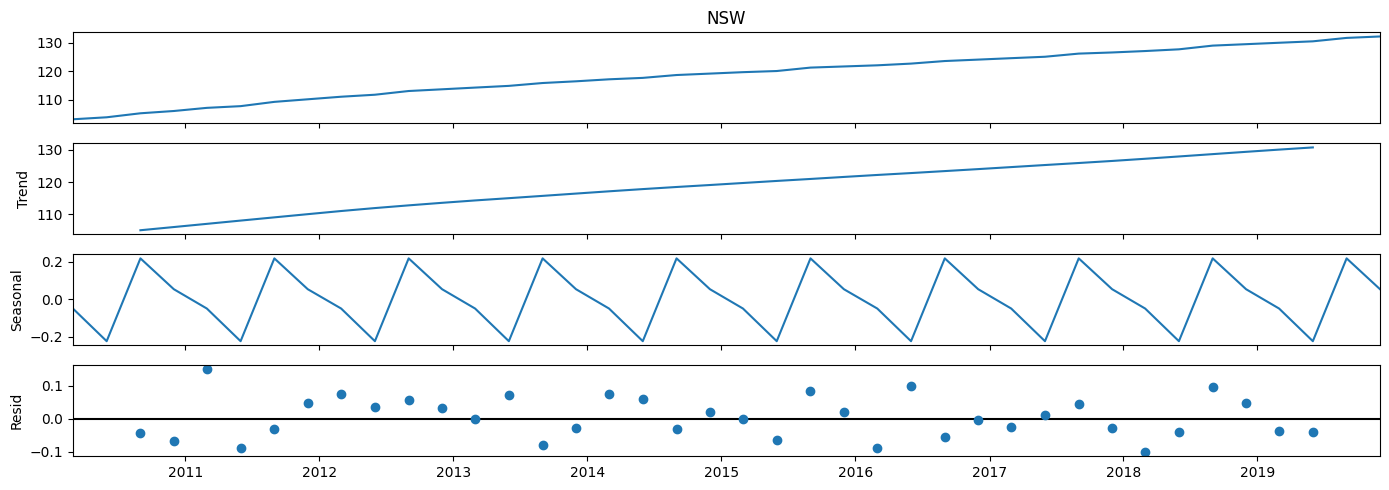

In [190]:
# NSW
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
decomposition = sm.tsa.seasonal_decompose(wages_pre_covid_nsw, model='additive')
decomposition.plot()
plt.savefig('NSW WPI seasonal_decompose.png')
plt.show()


Time series forecasting with ARIMA


In [191]:
def adfuller_test(wage):
    result=adfuller(wage)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(wages_pre_covid_nsw)

ADF Test Statistic : 0.10233211921497314
p-value : 0.966219958446506
#Lags Used : 4
Number of Observations : 35
weak evidence against null hypothesis,indicating it is non-stationary 


In [192]:
wages_pre_covid_nsw = wages_pre_covid_nsw.diff().dropna()

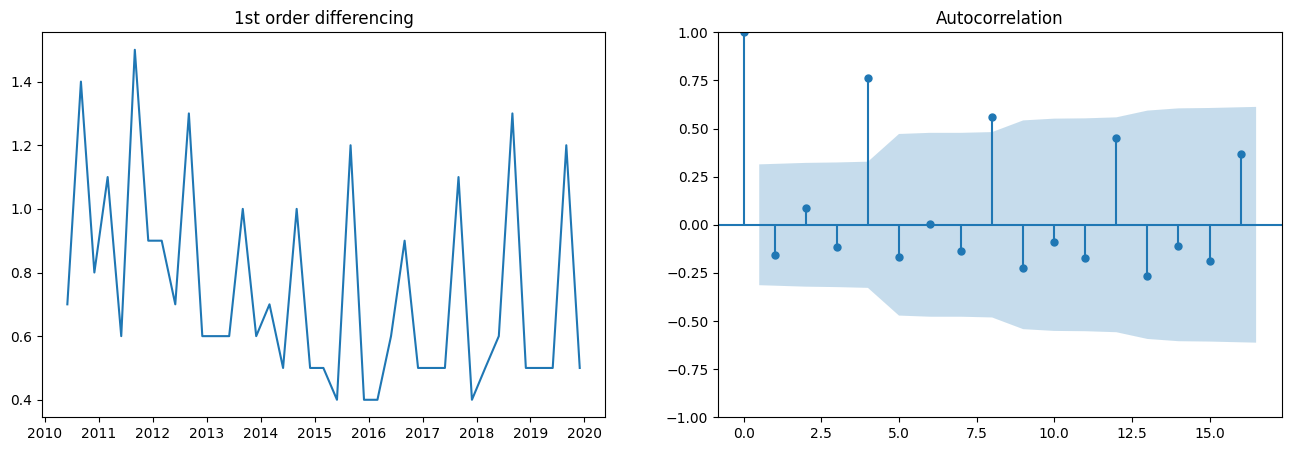

In [202]:
f = plt.figure()
f.set_figheight(5)
f.set_figwidth(16)
ax1 = f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(wages_pre_covid_nsw)

ax2 = f.add_subplot(122)
plot_acf(wages_pre_covid_nsw, ax=ax2)
plt.savefig('NSW WPI 1st order autococorrelation.png')
plt.show()

In [194]:
def adfuller_test(wage):
    result=adfuller(wage)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(wages_pre_covid_nsw)

ADF Test Statistic : -3.4902046879402904
p-value : 0.00824225098484166
#Lags Used : 10
Number of Observations : 28
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


As from the above observation, after the first order differencing, the p-value drops beyond the threshold order and shows strong evidence against the null hypothesis, sp taking "d" as 2. 

We see the 4th lag is the most significant. so p is 4.

There are 2 lags crossed the threshold, so q is 2.


In [195]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

for param_seasonal in seasonal_pdq:
    try:
        mod_nsw = sm.tsa.statespace.SARIMAX(wages_pre_covid_nsw,
                                            order=(3, 2, 2),
                                            seasonal_order=param_seasonal)
        results_nsw  = mod_nsw.fit()
        print('ARIMA(4, 1, 2)x{} - AIC:{}'.format(param_seasonal, results_nsw.aic))
    except:
        continue

ARIMA(4, 1, 2)x(0, 0, 0, 4) - AIC:-13.197460183931561


E:\Uni\research\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\Uni\research\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
E:\Uni\research\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
E:\Uni\research\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
E:\Uni\research\venv\lib\site-packages\statsmodels\tsa\

ARIMA(4, 1, 2)x(0, 0, 1, 4) - AIC:-18.8759288271034
ARIMA(4, 1, 2)x(0, 1, 0, 4) - AIC:-12.330573654397586


E:\Uni\research\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\Uni\research\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 2)x(0, 1, 1, 4) - AIC:-15.977811893311198
ARIMA(4, 1, 2)x(1, 0, 0, 4) - AIC:-11.099817748675452


E:\Uni\research\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\Uni\research\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
E:\Uni\research\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(4, 1, 2)x(1, 0, 1, 4) - AIC:-16.7023412489378


E:\Uni\research\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\Uni\research\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
E:\Uni\research\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(4, 1, 2)x(1, 1, 0, 4) - AIC:-13.995302255900096
ARIMA(4, 1, 2)x(1, 1, 1, 4) - AIC:-14.371151459173838


E:\Uni\research\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 2)x(0, 0, 0, 4) - AIC:-13.197460183931561
ARIMA(4, 1, 2)x(0, 0, 1, 4) - AIC:-18.8759288271034
ARIMA(4, 1, 2)x(0, 1, 0, 4) - AIC:-12.330573654397586
ARIMA(4, 1, 2)x(0, 1, 1, 4) - AIC:-15.977811893311198
ARIMA(4, 1, 2)x(1, 0, 0, 4) - AIC:-11.099817748675452
ARIMA(4, 1, 2)x(1, 0, 1, 4) - AIC:-16.7023412489378
ARIMA(4, 1, 2)x(1, 1, 0, 4) - AIC:-13.995302255900096
ARIMA(4, 1, 2)x(1, 1, 1, 4) - AIC:-14.371151459173838

In [196]:
#(p, d, q)

mod_nsw = sm.tsa.statespace.SARIMAX(wages_pre_covid_nsw,
                                order=(4, 1, 2),
                                seasonal_order=(0, 0, 1, 4))
results_nsw = mod_nsw.fit(disp=0)
print(results_nsw.summary())

E:\Uni\research\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
E:\Uni\research\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                                 NSW   No. Observations:                   39
Model:             SARIMAX(4, 1, 2)x(0, 0, [1], 4)   Log Likelihood                  20.135
Date:                             Sun, 22 Oct 2023   AIC                            -24.270
Time:                                     16:56:42   BIC                            -11.170
Sample:                                 06-01-2010   HQIC                           -19.609
                                      - 12-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0706      0.108     -0.653      0.514      -0.283       0.141
ar.L2         -0.0471      

E:\Uni\research\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


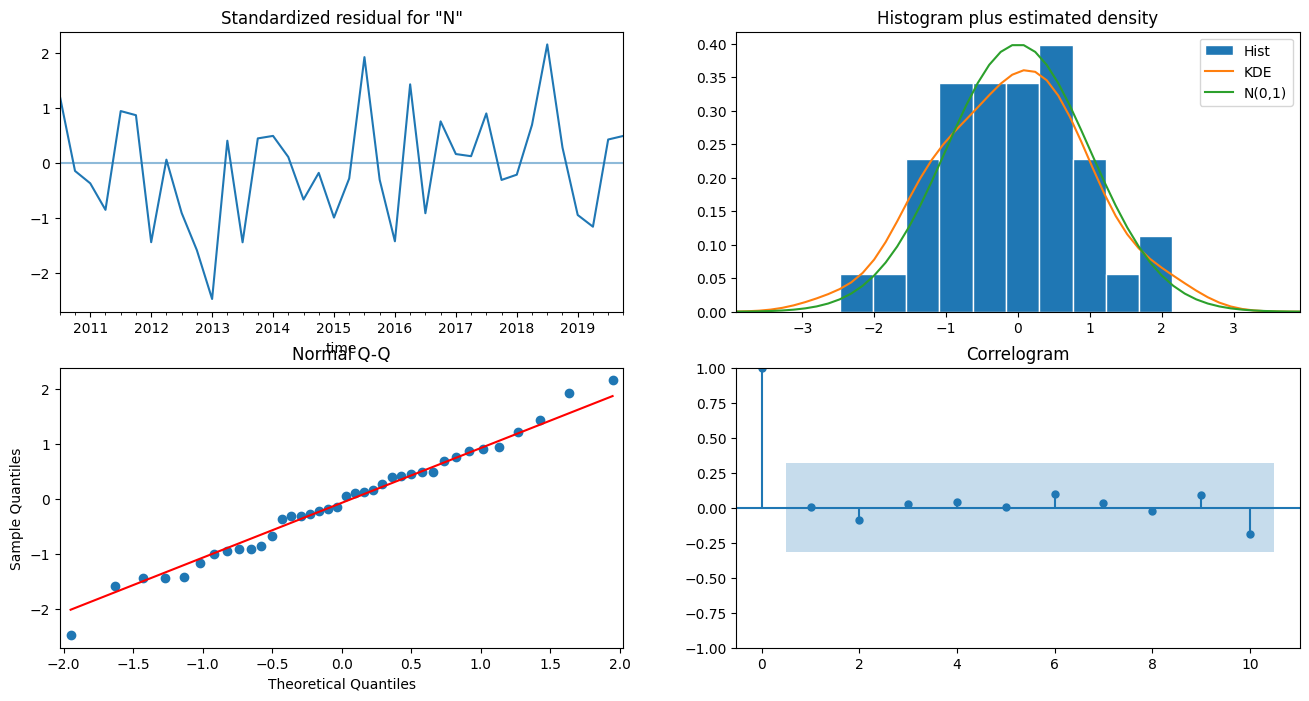

In [197]:
results_nsw.plot_diagnostics(figsize=(16, 8))
ax1.plot(wages_pre_covid_nsw)
plt.savefig('NSW WPI SARIMAX.png')
plt.show()

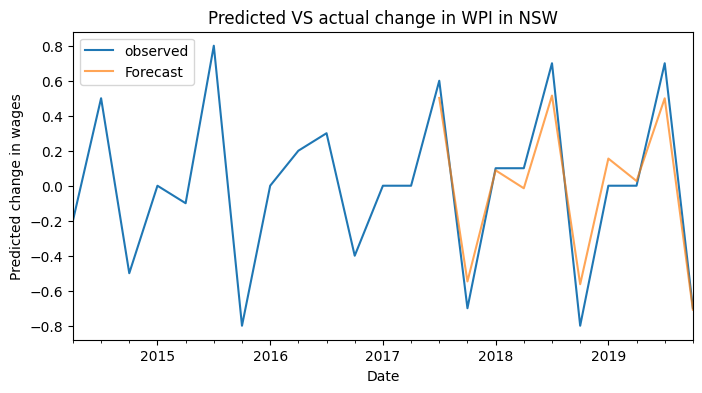

In [201]:
pred = results_nsw.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic=False)

ax = wages_pre_covid_nsw['2014':].diff().dropna().plot(label='observed')

pred.predicted_mean.diff().dropna().plot(ax=ax, label='Forecast', alpha=.7, figsize=(8, 4))

pred_ci = pred.conf_int()

ax.set_xlabel('Date')
ax.set_ylabel('Predicted change in wages')
plt.legend()
plt.title('Predicted VS actual change in WPI in NSW')

plt.savefig('NSW change in PWI predicted.png')
plt.show()


            lower NSW  upper NSW  Predictions
2020-03-01   0.295703   0.791154     0.543428
2020-06-01   0.345524   0.844605     0.595064
2020-09-01   0.906615   1.430679     1.168647
2020-12-01   0.194907   0.742737     0.468822
2021-03-01   0.245995   0.869767     0.557881
2021-06-01   0.289328   0.930081     0.609704
2021-09-01   0.830372   1.496528     1.163450
2021-12-01   0.112474   0.803241     0.457857
2022-03-01   0.184515   0.944266     0.564390
2022-06-01   0.235282   1.012206     0.623744
2022-09-01   0.756327   1.558756     1.157542
2022-12-01   0.033329   0.860807     0.447068
2023-03-01   0.125638   1.016754     0.571196
2023-06-01   0.183134   1.091280     0.637207


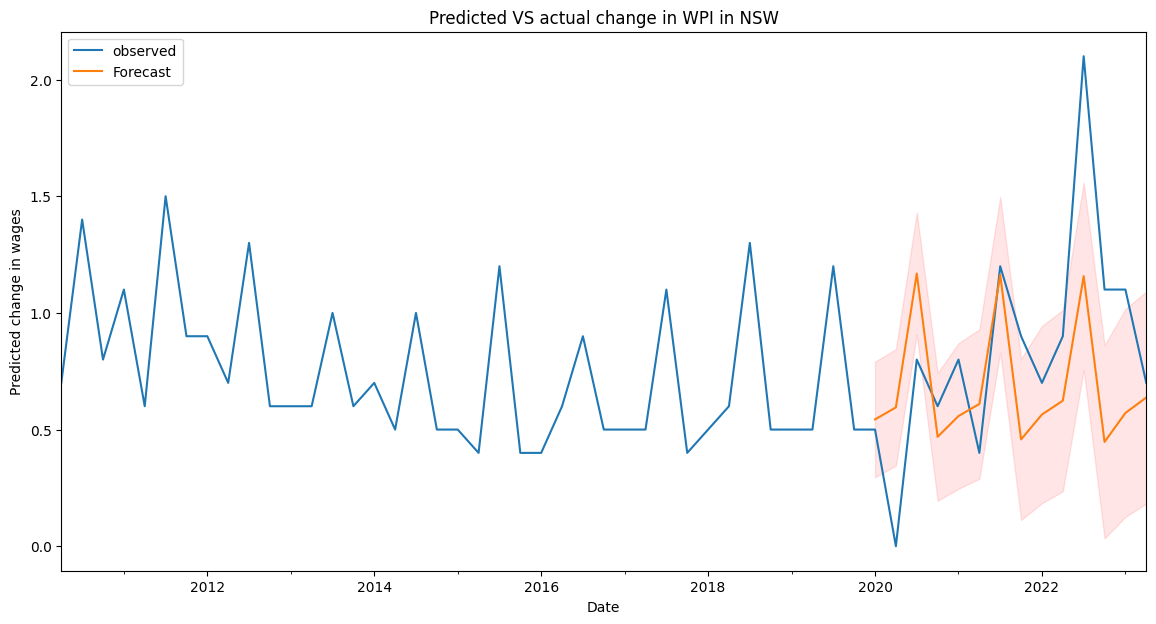

In [199]:
pred_uc = results_nsw.get_forecast(steps=14)
pred_ci = pred_uc.conf_int()
ax = wages_nsw.diff().dropna().plot(label='observed', figsize=(14, 7))

pred_ci["Predictions"] = pred_uc.predicted_mean
print(pred_ci)
ax.fill_between(
    pred_ci.index, pred_ci['lower NSW'], pred_ci['upper NSW'],
    color='r', alpha=0.1
)

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Predicted change in wages')
plt.legend()
plt.title('Predicted VS actual change in WPI in NSW')

plt.savefig('NSW change in PWI predicted.png')
plt.show()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7795      0.277     -2.817      0.005      -1.322      -0.237
ar.L2         -0.4337      0.476     -0.911      0.362      -1.366       0.499
ar.L3         -0.1952      0.401     -0.487      0.626      -0.981       0.591
ar.L4         -0.0653      0.185     -0.352      0.725      -0.429       0.298
sigma2         0.0197      0.008      2.367      0.018       0.003       0.036
             lower NSW   upper NSW  Predictions_wage
2020-03-01  132.524006  133.074764        132.799385
2020-06-01  132.951902  133.820933        133.386417
2020-09-01  133.950641  135.194145        134.572393
2020-12-01  134.231086  135.898415        135.064750
2021-03-01  134.580512  136.716509        135.648511
2021-06-01  135.013337  137.661098        136.337217
2021-09-01  136.128891  139.320350        137.724621
2021-12-01  136.427519 

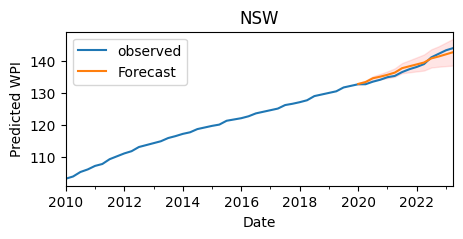

In [17]:
wages_pre_covid_nsw = wages_pre_covid['NSW']

mod_nsw = sm.tsa.statespace.SARIMAX(wages_pre_covid_nsw,
                                order=(4, 2, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_nsw = mod_nsw.fit()
print(results_nsw.summary().tables[1])
pred_uc = results_nsw.get_forecast(steps=14)
pred_ci = pred_uc.conf_int() 
pred_ci["Predictions_wage"] = pred_uc.predicted_mean
print(pred_ci)

ax = wages_nsw.plot(label='observed', figsize=(5, 2))
ax.fill_between(
    pred_ci.index, pred_ci['lower NSW'], pred_ci['upper NSW'],
    color='r', alpha=0.1
)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Predicted WPI')
plt.legend()
plt.title('NSW')


plt.savefig('NSW predicted PWI.png')
plt.show()